<a href="https://colab.research.google.com/github/NITIN9694/TensorFlow-Learning/blob/main/0_7_Transfer_Learning_With_Tensorflow_(Scalling_Up)_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Transfer Learning With Tensorflow part 3 : Scaling up

we've seen the power of tranfer learning  feature extraction and fine tuning, now its time to scale up to all of the class in food101
Our goal is to beat the original food101 papaer with 10% of tge training

In [ ]:
 #check GPU
 !nvidia-smi

Wed Sep 17 09:51:16 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   56C    P8             12W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

##Create helper funcations


In [6]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py

--2025-09-17 17:35:36--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2025-09-17 17:35:36 (114 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [7]:
#Import series of helper funcations  for our notebook
from helper_functions import create_tensorboard_callback , plot_loss_curves, unzip_data,walk_through_dir,compare_historys

#101 food classes : working with less data
our goal is to beat the original food101 papaer with 10% of the training data , so lets download it.

The data we're downloading come from the original food101 dataset but has been preprocessed using the image_data_modification


In [8]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

--2025-09-17 17:35:47--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.207, 142.250.4.207, 74.125.24.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip.1’

101_food_classes_10 100%[===================>]   1.51G  23.6MB/s    in 69s     

2025-09-17 17:36:57 (22.5 MB/s) - ‘101_food_classes_10_percent.zip.1’ saved [1625420029/1625420029]



In [ ]:
#how many images/class are there?
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/baby_back_ribs'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/spaghetti_bolognese'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/croque_madame'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/baklava'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/red_velvet_cake'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/cannoli'.
There are 0 directories and 75 

In [9]:
#setup data inputs
import tensorflow as tf
IMG_SIZE = (224,224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                               label_mode = "categorical",
                                                                               image_size = IMG_SIZE
                                                                                )

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode = "categorical",
                                                                image_size = IMG_SIZE,
                                                                shuffle= False
                                                                )

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


##Train Big dog model with transfer learning on 10% of 101 food class
Here are the steps we're going to take:



*   Create ModelCheckpoint Callback
*   Create a data agumentation layer to build data agumnetation right into the model

*   Build a headless funcational EfficientNetB0 backbond -model
*   Feature extract for 5 full passes (5 epochs on the train data and validat on 15% of the test data to save epoch time)



In [10]:
#create checpoint callback
checkpoint_path = "101_classes_10_percent_data_model_checkpoint.weights.h5"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only = True,
                                                         monitor = "val_accuracy",
                                                         save_best_only = True
                                                         )

In [11]:
#Create data augmentation layer to incorporate it right into the model

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomHeight, RandomWidth


#Setup data augmentation

data_augmentation =  Sequential(
    [
    RandomFlip("horizontal"),
    RandomRotation(0.2),
    RandomZoom(0.2),
    RandomHeight(0.2),
    RandomWidth(0.2)
    ],
     name = "data_augmentation" )

In [13]:
#setup base model and freeze it

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

base_model =  tf.keras.applications.efficientnet_v2.EfficientNetV2B0(
    include_top = False,
    input_shape = (224, 224, 3),
    weights = "imagenet"
)

base_model.trainable = False

input = layers.Input(shape = (224, 224, 3), name = "input_layer")
x = data_augmentation(input)

x = base_model(x,training=False)

# Global average pooling
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Output layer
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x)

model = tf.keras.Model(input, outputs)

In [16]:
#compile
model.compile(loss = "categorical_crossentropy",
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ["accuracy"]
              )

#fit
history_all_class_10_percenat = model.fit(
    train_data_all_10_percent,
    epochs = 5,

    validation_data =   test_data,
    validation_steps = int(0.25 * len(test_data)),
     callbacks = [checkpoint_callback]
                                          )

Epoch 1/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 68s 228ms/step - accuracy: 0.5582 - loss: 1.7530 - val_accuracy: 0.5260 - val_loss: 1.8314
Epoch 2/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 82s 228ms/step - accuracy: 0.6064 - loss: 1.5788 - val_accuracy: 0.5366 - val_loss: 1.7770
Epoch 3/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 82s 228ms/step - accuracy: 0.6139 - loss: 1.5409 - val_accuracy: 0.5387 - val_loss: 1.7322
Epoch 4/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 73s 191ms/step - accuracy: 0.6359 - loss: 1.4325 - val_accuracy: 0.5490 - val_loss: 1.7194
Epoch 5/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 45s 191ms/step - accuracy: 0.6361 - loss: 1.4124 - val_accuracy: 0.5563 - val_loss: 1.6791


In [17]:
#evaluate the modelm
fine_tuning_result = model.evaluate(test_data)
fine_tuning_result

790/790 ━━━━━━━━━━━━━━━━━━━━ 50s 63ms/step - accuracy: 0.5833 - loss: 1.5790


[1.5012741088867188, 0.5984950661659241]

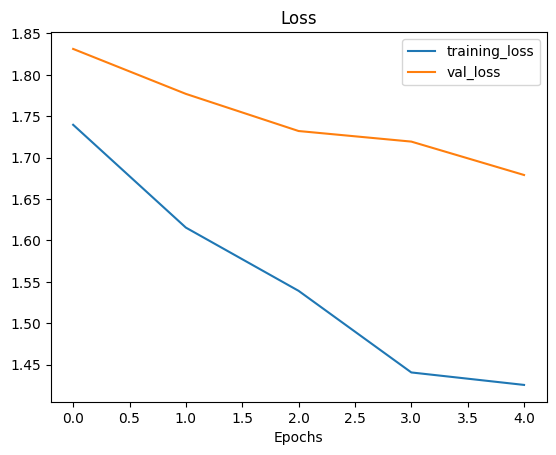

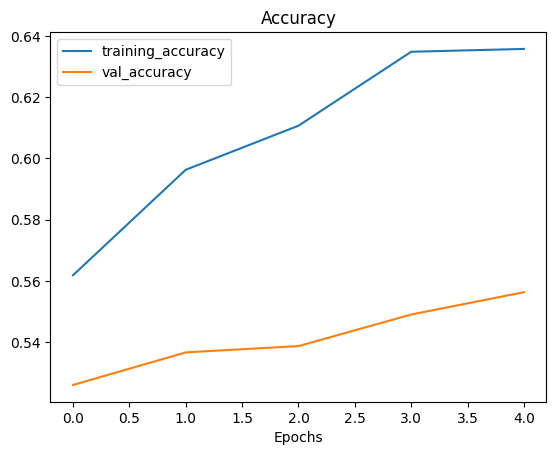

In [18]:
#Plot los curve
plot_loss_curves(history_all_class_10_percenat)